# Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1492 entries, 1 to 1492
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   INPUT0    1492 non-null   float64
 1   INPUT1    1492 non-null   float64
 2   INPUT2    1492 non-null   float64
 3   INPUT3    1492 non-null   float64
 4   INPUT4    1492 non-null   float64
 5   INPUT5    1492 non-null   float64
 6   INPUT6    1492 non-null   float64
 7   INPUT7    1492 non-null   float64
 8   INPUT8    1492 non-null   float64
 9   TARGET_X  1492 non-null   float64
 10  TARGET_Y  1492 non-null   float64
dtypes: float64(11)
memory usage: 139.9 KB


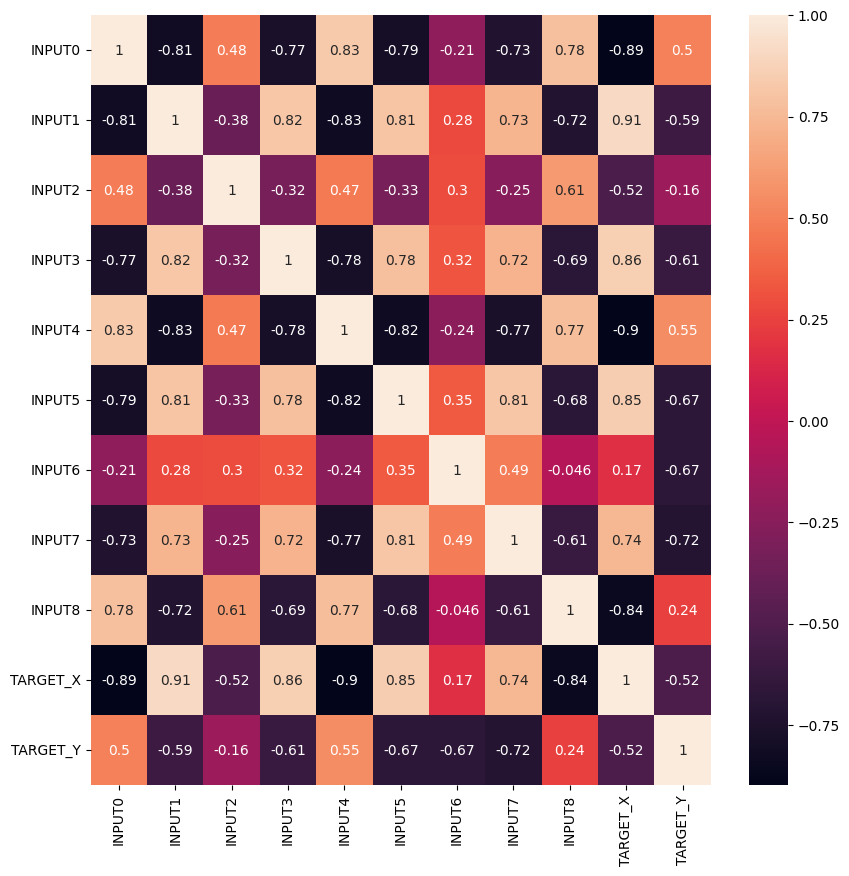

x_train  (1044, 9)
y_train  (1044, 2)
x_test  (448, 9)
y_test  (448, 2)


In [2]:
from set_extraction import x_train, y_train, x_test, y_test

# Models

In [3]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [4]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from skorch.helper import predefined_split
from skorch.dataset import Dataset
from time import time

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
results = []

# Neural Networks

## MLP

### Grid search for parameter setting 


In [ ]:
%pip install -U skorch

In [10]:
def MEE(actual, predict):
    return np.mean(np.linalg.norm(actual - predict, axis=-1))

In [13]:
in_dim = x_train.shape[1]     
out_dim = y_train.shape[1]

params = {
    'batch_size': [16],
    'max_epochs': [100],
    'module__dropout_rate': [0], # 0.1], #0.3
    'module__num_hidden_layers': [0, 1],
    'module__h_units': [50, 40, 30],  #60
    'module__activation': [nn.ReLU, nn.Tanh],
    'optimizer__lr': [0.008, 0.01, 0.02], 
    'optimizer__momentum': [0.0, 0.01, 0.03, 0.1, 0.5],
    'optimizer__weight_decay': [0.0001, 0.001, 0.01, 0.1]
}

In [14]:
# Define the class for single layer NN 
class mlp_net(nn.Module):    
    # Constructor
    def __init__(self, h_units, num_hidden_layers, activation, dropout_rate):
        super().__init__()

        self.layers = []
        self.acts = []
        self.drops = []

        self.layers.append(nn.Linear(in_dim, h_units))
        self.acts.append(activation())
        if dropout_rate != 0:
            self.drops.append(nn.Dropout(dropout_rate))
            self.add_module(f"dro0", self.drops[-1])
        self.add_module(f"layer0", self.layers[-1])
        self.add_module(f"act0", self.acts[-1])
        

        for i in range(1, num_hidden_layers+1):
            h_units_out = h_units
            self.layers.append(nn.Linear(h_units, h_units_out))
            self.acts.append(activation())
            if dropout_rate != 0:
                self.drops.append(nn.Dropout(dropout_rate))
                self.add_module(f"dro{i}", self.drops[-1])
            self.add_module(f"layer{i}", self.layers[-1])
            self.add_module(f"act{i}", self.acts[-1])

        self.output = nn.Linear(h_units, out_dim)
        
    # prediction function
    def forward(self, x):

        if len(self.drops) > 0:
            for layer, act, dro in zip(self.layers, self.acts, self.drops):
                x = act(layer(x))
                x = dro(x)
        else:
            for layer, act in zip(self.layers, self.acts):
                x = act(layer(x))
        x = self.output(x)
        
        return x


In [15]:
from skorch.callbacks import EarlyStopping

early_stopping = EarlyStopping(
                              patience=20,                              
                              monitor="valid_loss",
                              lower_is_better=True,
                              load_best=True,
                              threshold=0.01
                              )

In [16]:
from skorch.callbacks import BatchScoring, EpochScoring
MEEcall_v = BatchScoring(scoring=make_scorer(MEE, greater_is_better = False), name='valid_MEE')
MEEcall_t = BatchScoring(scoring=make_scorer(MEE, greater_is_better = False), on_train=True, name='MEE')

In [17]:
#hyperparameter tuning with grid search CV
n_jobs_search = -1

start=time()

mlp = NeuralNetRegressor(
    mlp_net,
    criterion=nn.MSELoss,
    optimizer = optim.SGD, 
    verbose=True,
    callbacks=[early_stopping, MEEcall_v, MEEcall_t]
)

mlp_cv = GridSearchCV(estimator=mlp, param_grid=params, scoring=make_scorer(MEE, greater_is_better = False), 
                      cv=5, verbose=4, n_jobs=n_jobs_search) 
mlp_cv.fit(x_train, y_train)

print('time for grid search = {:.0f} sec'.format(time()-start))

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
  epoch      MEE    train_loss    valid_MEE    valid_loss     dur
-------  -------  ------------  -----------  ------------  ------
      1  -7.4358       62.7751      -2.5533        5.0841  0.0436
      2  -2.0454        3.0440      -2.1191        3.4874  0.0604
      3  -1.8209        2.4514      -2.0196        3.0838  0.0779
      4  -1.7254        2.2446      -1.9549        2.8813  0.0765
      5  -1.6636        2.1278      -1.9010        2.7439  0.0393
      6  -1.6244        2.0570      -1.8542        2.6354  0.0410
      7  -1.5987        2.0095      -1.8141        2.5465  0.0596
      8  -1.5799        1.9746      -1.7806        2.4734  0.0461
      9  -1.5650        1.9471      -1.7530        2.4127  0.0518
     10  -1.5526        1.9244      -1.7304        2.3616  0.0537
     11  -1.5420        1.9050      -1.7110        2.3178  0.0715
     12  -1.5328        1.8881      -1.6939        2.2796  0.0546
     13  -1.

In [18]:
mlp_cv.best_params_

{'batch_size': 16,
 'max_epochs': 100,
 'module__activation': torch.nn.modules.activation.Tanh,
 'module__dropout_rate': 0,
 'module__h_units': 40,
 'module__num_hidden_layers': 1,
 'optimizer__lr': 0.01,
 'optimizer__momentum': 0.0,
 'optimizer__weight_decay': 0.001}

In [19]:
# validation
mlp_cv.best_score_

-1.473409652709961

In [20]:
best_ep_est = len(mlp_cv.best_estimator_.history[:, 'train_loss'])-20

In [21]:
best_ep_est

80

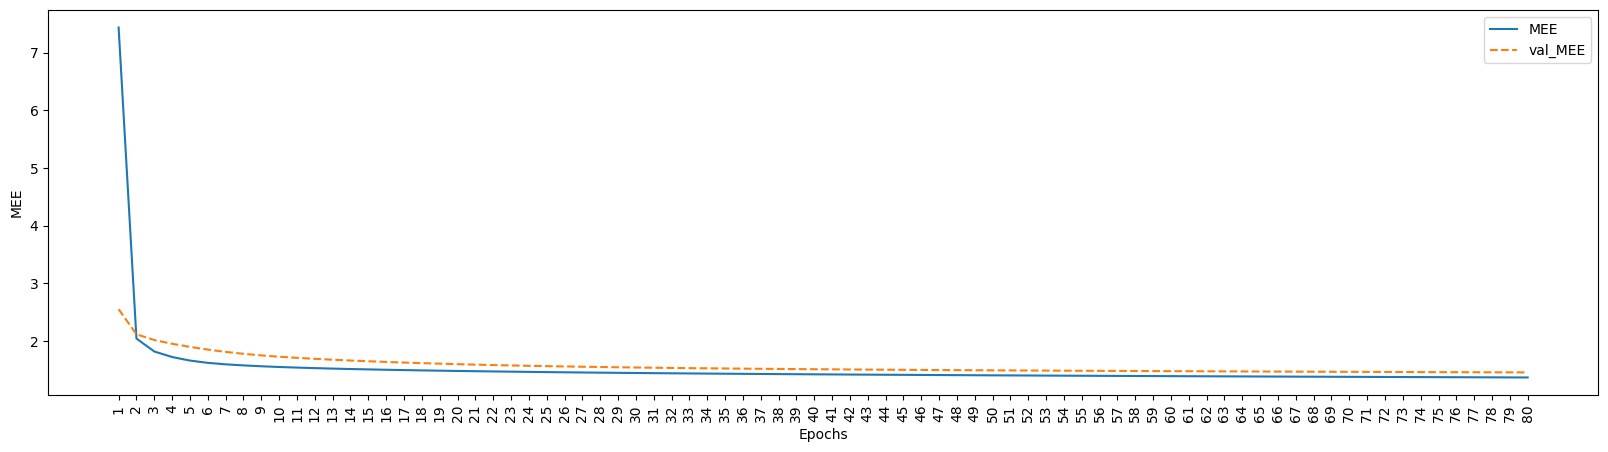

In [22]:
#MEE plot
plt.figure(figsize = (20,5))
plt.plot(-pd.DataFrame(mlp_cv.best_estimator_.history[:, 'MEE'][0:best_ep_est]), label='MEE') 
plt.plot(-pd.DataFrame(mlp_cv.best_estimator_.history[:, 'valid_MEE'][0:best_ep_est]), label='val_MEE', linestyle='dashed')       
plt.xlabel('Epochs')
plt.ylabel('MEE')
#plt.ylim([0,10])
plt.xticks(np.arange(len(mlp_cv.best_estimator_.history[:, 'MEE'][0:best_ep_est])), 
           np.arange(1, len(mlp_cv.best_estimator_.history[:, 'MEE'][0:best_ep_est])+1), 
           rotation=90)
plt.legend(loc = 'upper right')

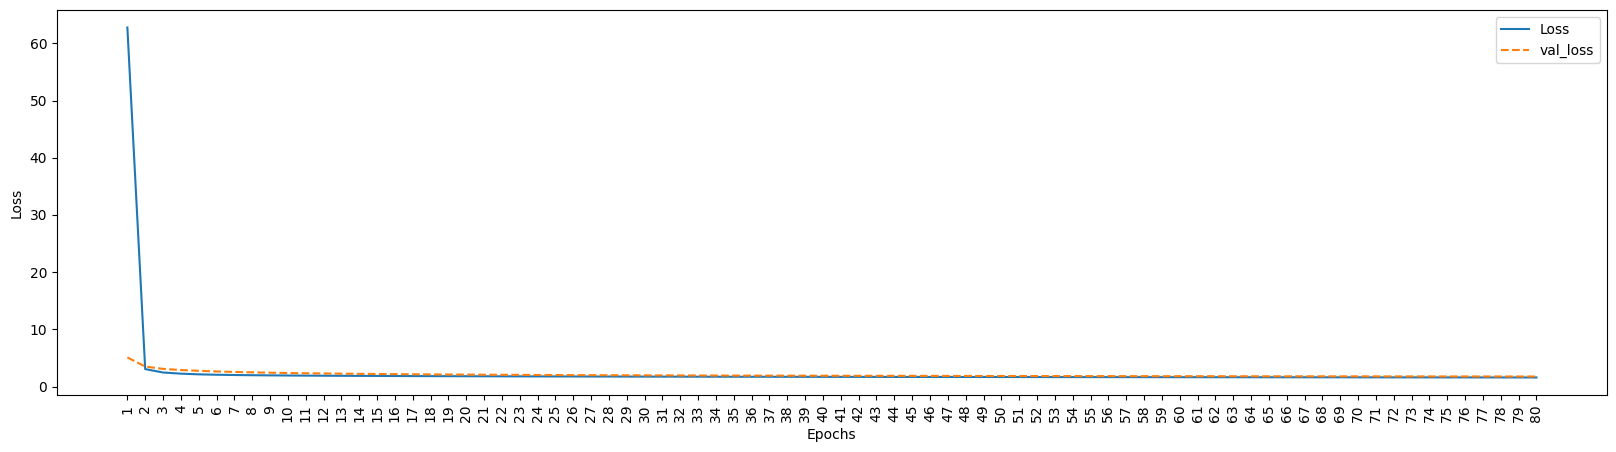

In [23]:
#Loss plot
plt.figure(figsize = (20,5))
plt.plot(pd.DataFrame(mlp_cv.best_estimator_.history[:, 'train_loss'][0:best_ep_est]), label='Loss') 
plt.plot(pd.DataFrame(mlp_cv.best_estimator_.history[:, 'valid_loss'][0:best_ep_est]), label='val_loss', linestyle='dashed')       
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,10])
plt.xticks(np.arange(len(mlp_cv.best_estimator_.history[:, 'train_loss'][0:best_ep_est])), 
           np.arange(1, len(mlp_cv.best_estimator_.history[:, 'train_loss'][0:best_ep_est])+1), 
           rotation=90)
plt.legend(loc = 'upper right')

  epoch       MEE    train_loss    valid_MEE    valid_loss     dur
-------  --------  ------------  -----------  ------------  ------
      1  -27.9218      405.4014     -21.4029      236.8204  0.0034
      2  -14.5650      125.0172      -7.3399       31.5038  0.0053
      3  -5.9488       20.6249      -6.1652       22.8269  0.0053
      4  -4.9433       15.0452      -5.5313       18.9542  0.0060
      5  -4.3838       12.2083      -4.9347       15.5663  0.0040
      6  -3.8658        9.6898      -4.3696       12.4154  0.0030
      7  -3.4130        7.5850      -3.8020        9.7427  0.0140
      8  -3.0155        5.9925      -3.3694        7.8689  0.0046
      9  -2.7134        4.9345      -3.0697        6.6247  0.0030
     10  -2.4885        4.2386      -2.8674        5.7971  0.0107
     11  -2.3161        3.7645      -2.7383        5.2340  0.0040
     12  -2.1836        3.4281      -2.6478        4.8374  0.0030
     13  -2.0819        3.1803      -2.5780        4.5463  0.0038
     1

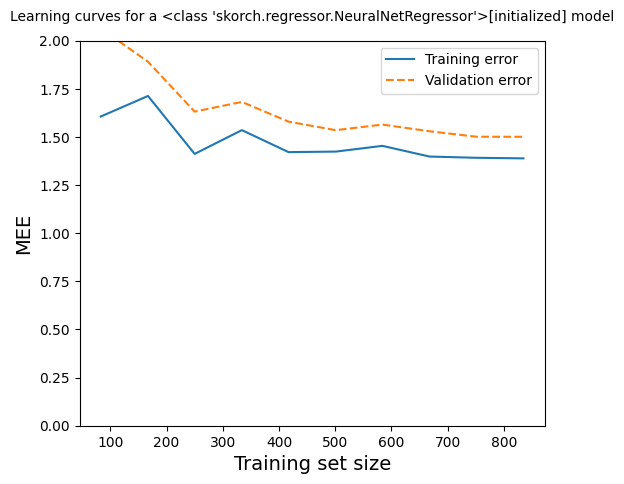

In [24]:
from sklearn.model_selection import learning_curve

### Bundling our previous work into a function ###
def learning_curves(estimator, x, y, train_sizes, cv):

    scoring = make_scorer(MEE, greater_is_better = False)

    train_sizes, train_scores, validation_scores = learning_curve(estimator, x, y, train_sizes=train_sizes,
                                                                cv = cv, scoring = scoring)
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error', linestyle='dashed')

    plt.ylabel('MEE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 10, y = 1.03)
    plt.legend()
    plt.ylim(0,2)

### Plotting the learning curves ###
plt.figure(figsize = (6,5))

learning_curves(mlp_cv.best_estimator_, x_train, y_train, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 5)

In [25]:
# save the model to disk
joblib.dump(mlp_cv.best_estimator_, 'cup_models/pytorch.z')

['cup_models/pytorch.z']

In [26]:
# Final retraining -------------------------------------------------------------------------

In [28]:
final_models = []
models_train_mse = []
models_val_mse = []
models_train_mee = []
models_val_mee = []

for i in range(1,6):

    model = NeuralNetRegressor(
        mlp_net,
        criterion=nn.MSELoss,
        optimizer = optim.SGD, 
        verbose=True,
        callbacks=[early_stopping, MEEcall_v, MEEcall_t],
        **mlp_cv.best_params_
    )
    
    hist = model.fit(x_train, y_train)           

    models_train_mse.append(hist.history[:, 'train_loss'])
    models_val_mse.append(hist.history[:, 'valid_loss'])
    models_train_mee.append(list(map(lambda x: -x, hist.history[:, 'MEE'])))
    models_val_mee.append(list(map(lambda x: -x, hist.history[:, 'valid_MEE'])))

    final_models.append(model)

    print("Trial", i)

  epoch      MEE    train_loss    valid_MEE    valid_loss     dur
-------  -------  ------------  -----------  ------------  ------
      1  -7.1094       57.9986      -2.8365        6.2043  0.0307
      2  -1.9925        2.9450      -2.0539        3.3247  0.0311
      3  -1.7634        2.3606      -1.8923        2.7312  0.0340
      4  -1.6876        2.1891      -1.8322        2.5505  0.0427
      5  -1.6413        2.0992      -1.7949        2.4585  0.0359
      6  -1.6121        2.0438      -1.7671        2.3970  0.0409
      7  -1.5916        2.0052      -1.7452        2.3514  0.0470
      8  -1.5759        1.9761      -1.7273        2.3157  0.0361
      9  -1.5632        1.9528      -1.7123        2.2864  0.0337
     10  -1.5526        1.9332      -1.6991        2.2610  0.0424
     11  -1.5436        1.9162      -1.6872        2.2381  0.0357
     12  -1.5356        1.9011      -1.6764        2.2168  0.0402
     13  -1.5286        1.8875      -1.6663        2.1966  0.0431
     14  -

In [29]:
last = [el[-21] for el in models_val_mse]
last

[1.7602728673002936,
 1.763316891410134,
 1.7331600547122044,
 1.7551550441666652,
 1.7457360773565667]

In [30]:
# median model btw 5 trials
final_idx = np.argsort(last)[len(last)//2]
final_idx

3

In [31]:
models_val_mee[final_idx][-21]

1.456361414142773

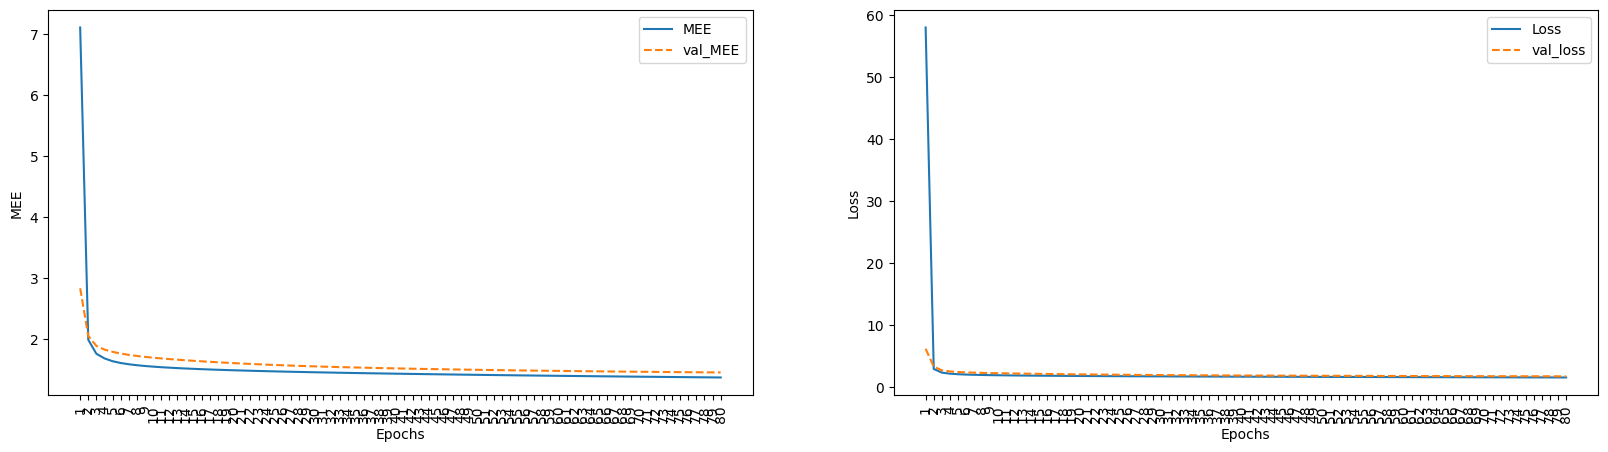

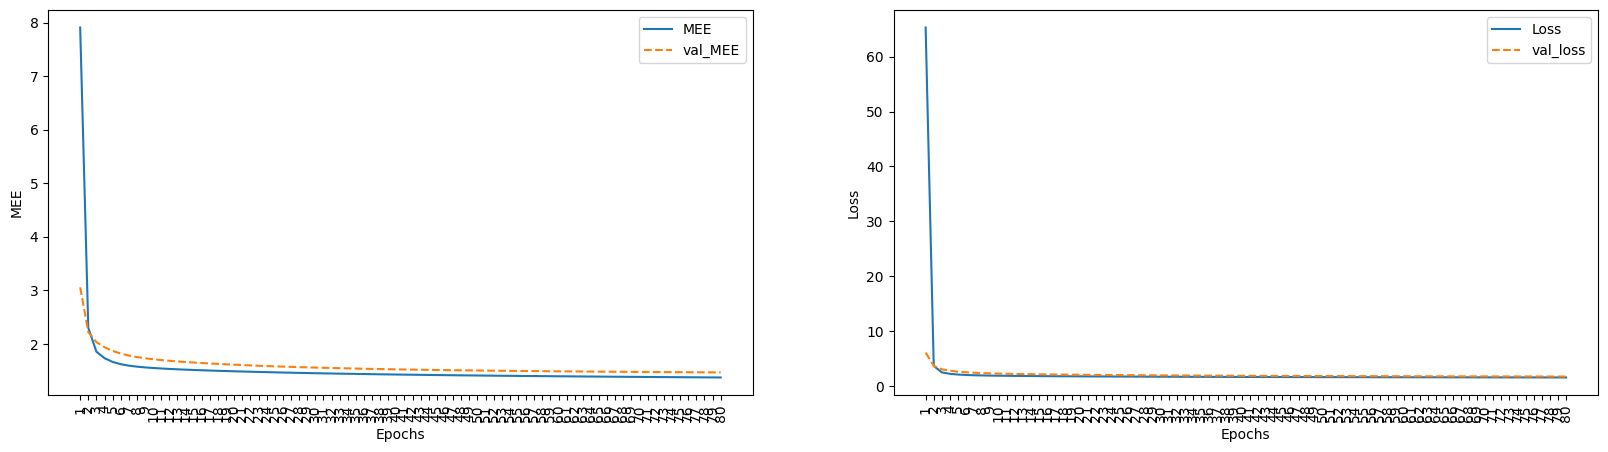

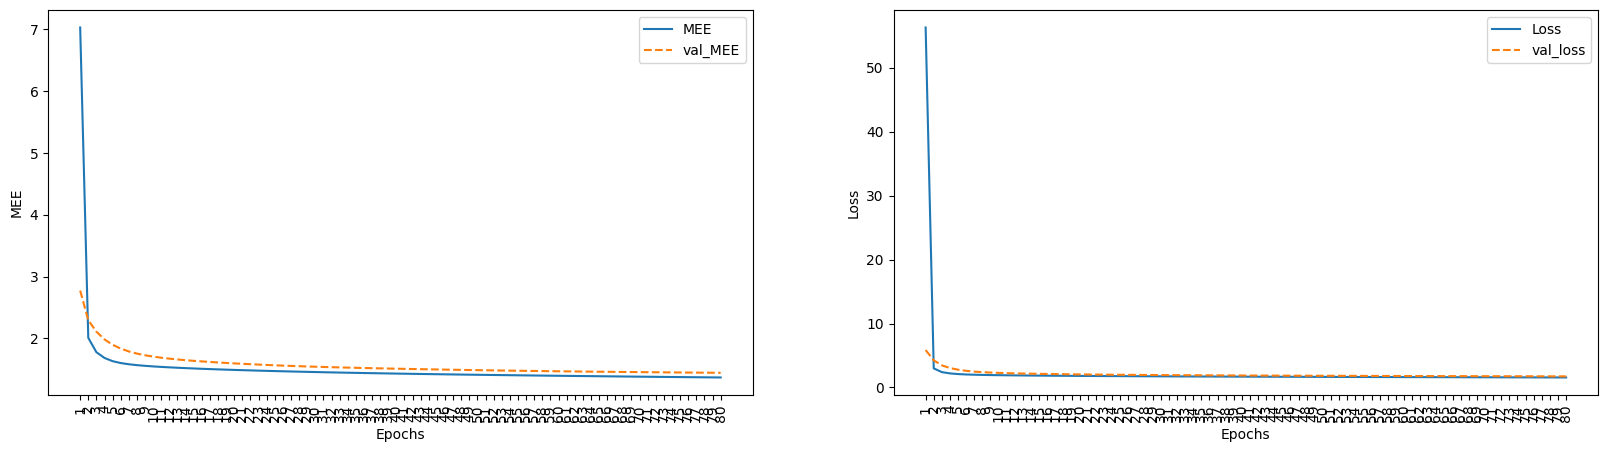

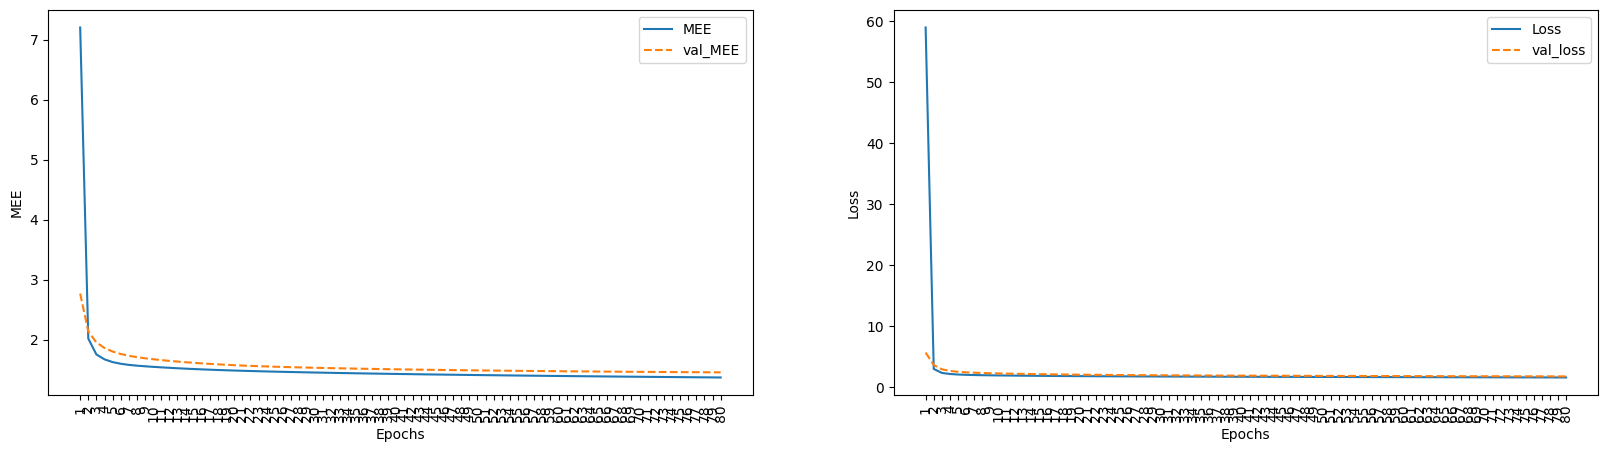

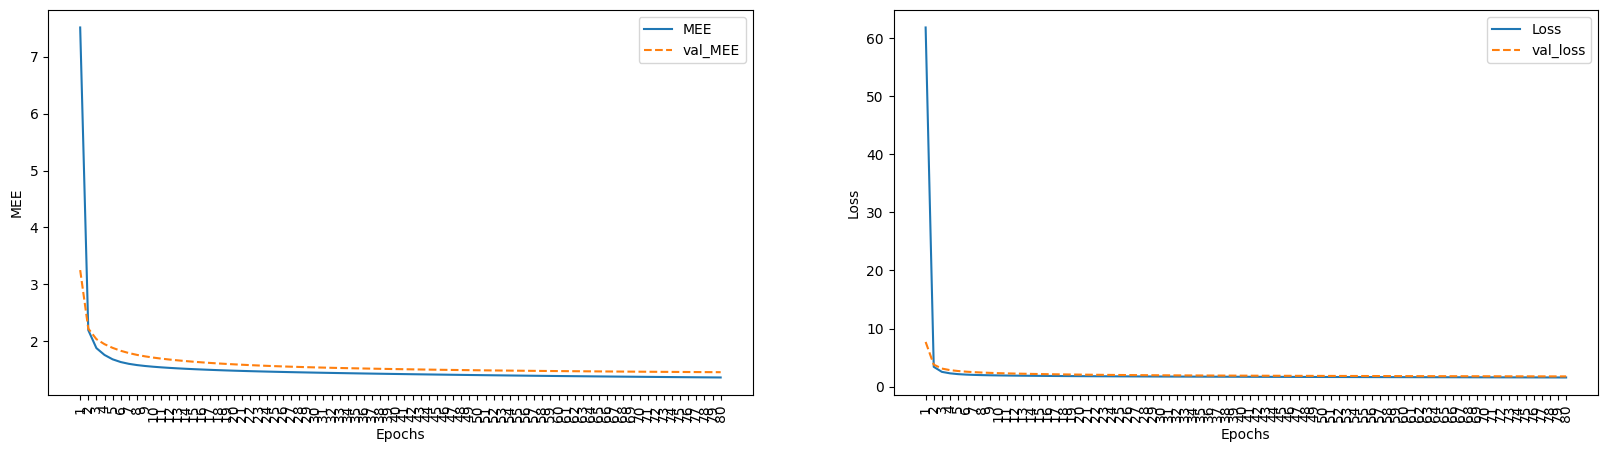

In [32]:
for i in range(5):

    b_ep = len(models_train_mee[i])-20

    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    #MEE plot
    axs[0].plot(models_train_mee[i][0:b_ep], label='MEE') 
    axs[0].plot(models_val_mee[i][0:b_ep], label='val_MEE', linestyle='dashed')       
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('MEE')
    #plt.ylim([0,5])
    axs[0].set_xticks(np.arange(len(models_train_mee[i][0:b_ep])), 
                        np.arange(1, len(models_train_mee[i][0:b_ep])+1), 
                        rotation=90)
    axs[0].legend(loc = 'upper right')

    #Loss plot
    axs[1].plot(models_train_mse[i][0:b_ep], label='Loss') 
    axs[1].plot(models_val_mse[i][0:b_ep], label='val_loss', linestyle='dashed')       
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    #plt.ylim([0,5])
    axs[1].set_xticks(np.arange(len(models_train_mse[i][0:b_ep])), 
            np.arange(1, len(models_train_mse[i][0:b_ep])+1), 
            rotation=90)
    axs[1].legend(loc = 'upper right')

    plt.show()

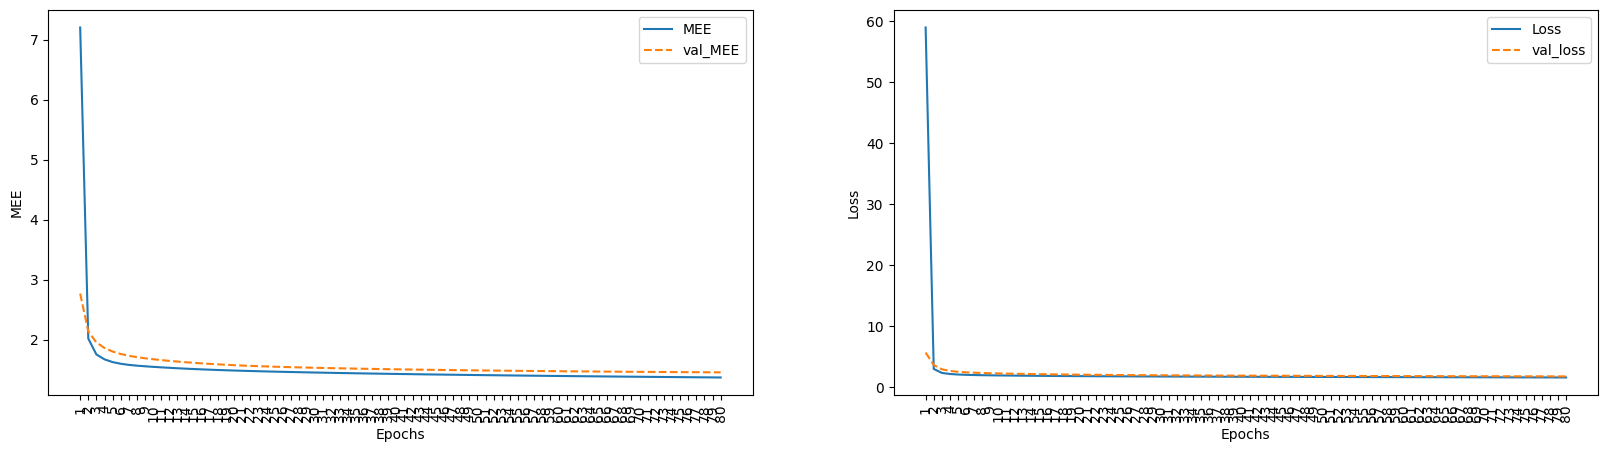

In [33]:
b_ep = len(models_train_mee[final_idx])-20

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
#MEE plot
axs[0].plot(models_train_mee[final_idx][0:b_ep], label='MEE') 
axs[0].plot(models_val_mee[final_idx][0:b_ep], label='val_MEE', linestyle='dashed')       
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MEE')
#plt.ylim([0,5])
axs[0].set_xticks(np.arange(len(models_train_mee[final_idx][0:b_ep])), 
                np.arange(1, len(models_train_mee[final_idx][0:b_ep])+1), 
                rotation=90)
axs[0].legend(loc = 'upper right')

#Loss plot
axs[1].plot(models_train_mse[final_idx][0:b_ep], label='Loss') 
axs[1].plot(models_val_mse[final_idx][0:b_ep], label='val_loss', linestyle='dashed')       
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
#plt.ylim([0,5])
axs[1].set_xticks(np.arange(len(models_train_mse[final_idx][0:b_ep])), 
        np.arange(1, len(models_train_mse[final_idx][0:b_ep])+1), 
        rotation=90)
axs[1].legend(loc = 'upper right')

plt.show()

  epoch       MEE    train_loss    valid_MEE    valid_loss     dur
-------  --------  ------------  -----------  ------------  ------
      1  -28.1718      410.6184     -22.8563      266.9560  0.0045
      2  -16.6381      155.2941      -8.1590       37.6204  0.0040
      3  -6.3504       23.2630      -5.7835       19.8821  0.0060
      4  -4.7582       13.7577      -5.2023       16.6201  0.0070
      5  -4.1812       11.0449      -4.4118       12.6370  0.0081
      6  -3.6085        8.3131      -3.8903       10.1767  0.0050
      7  -3.2383        6.7521      -3.4589        8.3711  0.0060
      8  -2.9438        5.6561      -3.1603        7.0877  0.0080
      9  -2.6985        4.8673      -2.9454        6.1848  0.0070
     10  -2.4968        4.2821      -2.7995        5.5505  0.0090
     11  -2.3333        3.8388      -2.7045        5.0993  0.0060
     12  -2.2044        3.4964      -2.6366        4.7698  0.0060
     13  -2.1004        3.2258      -2.5816        4.5204  0.0050
     1

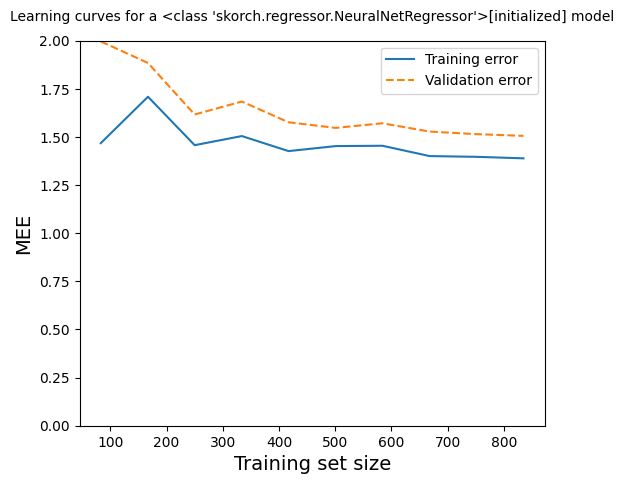

In [34]:
### Plotting the learning curves ###
plt.figure(figsize = (6,5))

learning_curves(final_models[final_idx], x_train, y_train, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 5)

In [35]:
joblib.dump(final_models[final_idx], 'cup_models/pytorch_median.z')

['cup_models/pytorch_median.z']

In [ ]:
# --------------------------------------------------------------------------------------------

### Final model

In [36]:
pytorch = joblib.load('cup_models/pytorch.z')

In [37]:
pytorch

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=mlp_net(
    (layer0): Linear(in_features=9, out_features=40, bias=True)
    (act0): Tanh()
    (layer1): Linear(in_features=40, out_features=40, bias=True)
    (act1): Tanh()
    (output): Linear(in_features=40, out_features=2, bias=True)
  ),
)

In [38]:
train_pred_pytorch = pytorch.predict(x_train)

In [39]:
print('MEE train set ', MEE(y_train, train_pred_pytorch))

MEE train set  1.3557272


In [40]:
test_pred_pytorch = pytorch.predict(x_test)

In [41]:
print('MEE test set ', MEE(y_test, test_pred_pytorch))

MEE test set  1.482181


[Text(0.5, 0, 'target_x'), Text(0, 0.5, 'target_y'), Text(0.5, 1.0, 'Targets')]

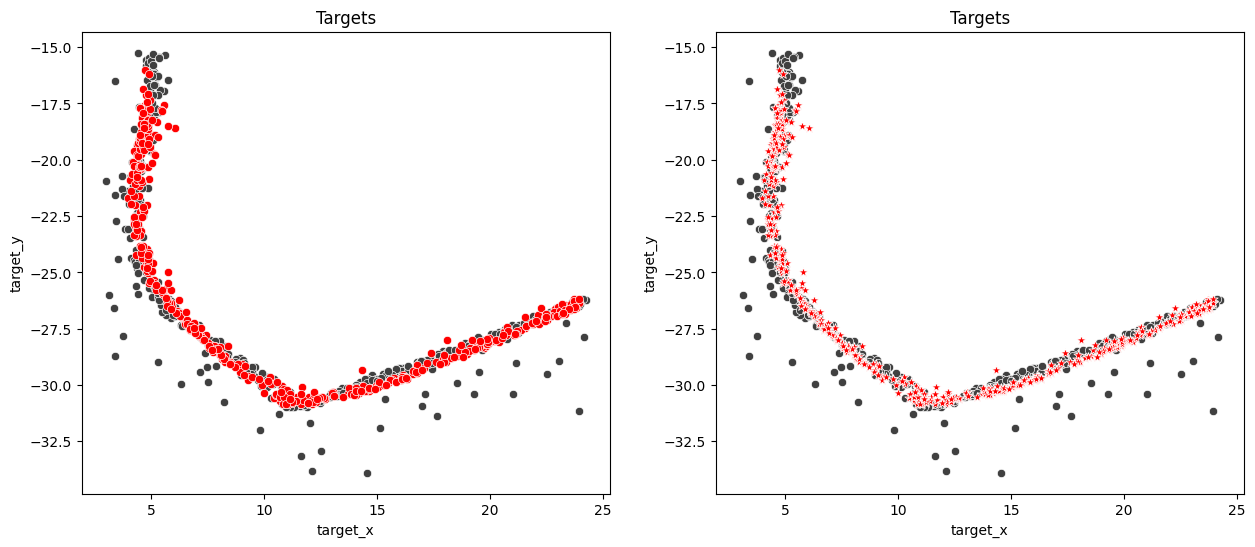

In [44]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.25',ax=ax[0])
sns.scatterplot(x=test_pred_pytorch[:,0],y=test_pred_pytorch[:,1],color='r',ax=ax[0])
ax[0].set(xlabel='target_x',ylabel='target_y',title='Targets')

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.25',ax=ax[1])
sns.scatterplot(x=test_pred_pytorch[:,0],y=test_pred_pytorch[:,1],color='r',ax=ax[1], marker='*', s=50)
ax[1].set(xlabel='target_x',ylabel='target_y',title='Targets')

[Text(0.5, 0, 'target_x'), Text(0, 0.5, 'target_y'), Text(0.5, 1.0, 'Targets')]

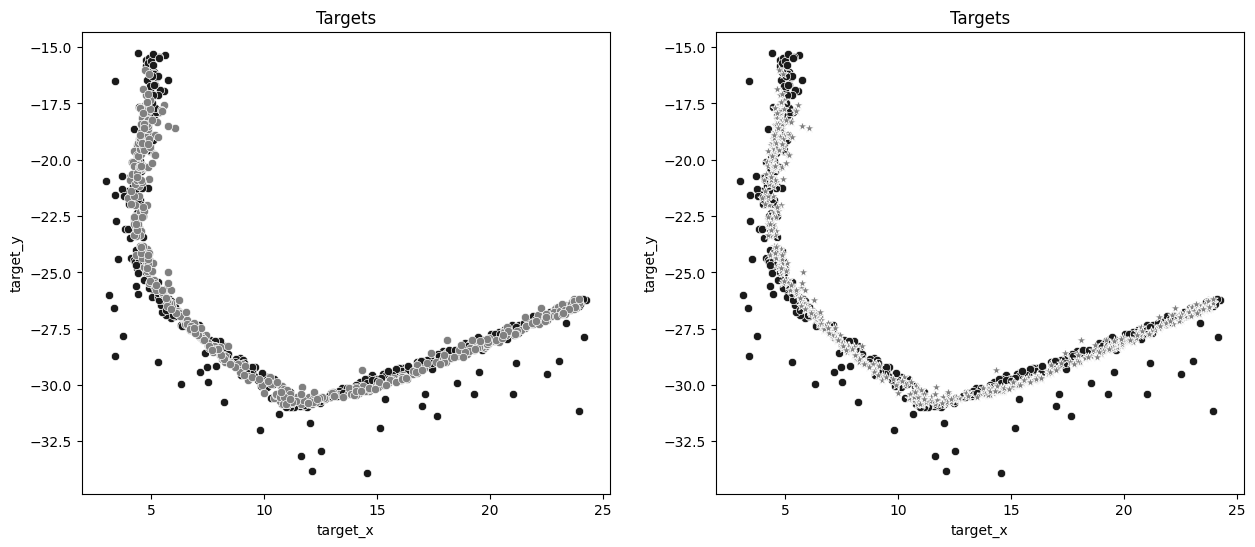

In [45]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.1',ax=ax[0])
sns.scatterplot(x=test_pred_pytorch[:,0],y=test_pred_pytorch[:,1],color='.5',ax=ax[0])
ax[0].set(xlabel='target_x',ylabel='target_y',title='Targets')

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.1',ax=ax[1])
sns.scatterplot(x=test_pred_pytorch[:,0],y=test_pred_pytorch[:,1],color='.5',ax=ax[1], marker='*', s=50)
ax[1].set(xlabel='target_x',ylabel='target_y',title='Targets')

In [46]:
results.append(('MLP_pytorch train', MEE(y_train, train_pred_pytorch)))
results.append(('MLP_pytorch validation', mlp_cv.best_score_))

# Summary

In [47]:
for i in range(len(results)):
  print(results[i])

('MLP_pytorch train', 1.3557272)
('MLP_pytorch validation', -1.473409652709961)


In [48]:
pytorch_median = joblib.load('cup_models/pytorch_median.z')
pytorch_median

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=mlp_net(
    (layer0): Linear(in_features=9, out_features=40, bias=True)
    (act0): Tanh()
    (layer1): Linear(in_features=40, out_features=40, bias=True)
    (act1): Tanh()
    (output): Linear(in_features=40, out_features=2, bias=True)
  ),
)

In [49]:
train_pred_pytorch_median = pytorch_median.predict(x_train)
print('MEE train set ', MEE(y_train, train_pred_pytorch_median))

print('MEE val set', models_val_mee[final_idx][-21])

MEE train set  1.3627244
MEE val set 1.456361414142773


In [50]:
test_pred_pytorch_median = pytorch_median.predict(x_test)
print('MEE test set ', MEE(y_test, test_pred_pytorch_median))

MEE test set  1.4847806
